# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from tqdm import tqdm
from IPython.display import clear_output

from random import randint

In [2]:
np.random.seed(42)

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/01b_autoencoder'

# Loading data

In [4]:
path_to_data = './../../qualitative_analysis/data/preprocessed_data/ftir_scaled_train.csv'
path_to_description = './../../qualitative_analysis/data/preprocessed_data/ftir_description.csv'

## Scaled spectra

In [5]:
data_scaled = pd.read_csv(path_to_data, index_col=0)

print(data_scaled.shape)
data_scaled.head(3)

(26, 1142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
wavenumber,1900.766600,1899.802230,1898.837870,1897.873500,1896.909130,1895.944770,1894.980400,1894.016030,1893.051670,1892.087300,1891.122930,1890.158570,1889.194200,1888.229830,1887.265470,1886.301100,1885.336730,1884.372370,1883.408000,1882.44364,1881.479270,1880.514900,1879.550540,1878.586170,1877.621800,...,823.569090,822.604720,821.640360,820.675990,819.711620,818.747260,817.782890,816.818520,815.854160,814.889790,813.925420,812.961060,811.996690,811.032320,810.067960,809.103590,808.139230,807.174860,806.210490,805.246130,804.281760,803.317390,802.353030,801.388660,800.424290
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.00668,0.007079,0.007509,0.007974,0.008476,0.009019,...,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.00007,0.000113,0.000168,0.000236,0.000318,0.000415,...,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997


## Samples description

In [6]:
samples_description = pd.read_csv(path_to_description, index_col=0)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


# Data wrangling

In [7]:
samples_description = (
    samples_description
    .loc[samples_description['Label'] == 'Train']
    .drop(columns=['Label'])
)

samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(25, 3)


,Description,Type,Class
1,"MFGO, разб. 1:20",$GO$,1
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1


In [8]:
wavenumber = data_scaled.iloc[0]
data = data_scaled.iloc[1:, :]

# selecting only go data
go_indexes = samples_description.loc[samples_description['Type'] == '$GO$'].index
go_data = data.loc[go_indexes]

# selecting only go dialysis data
god_indexes = samples_description.loc[samples_description['Type'] == '$GO_{d}$'].index
god_data = data.loc[god_indexes]

# selecting only rgo data
rgo_indexes = samples_description.loc[samples_description['Type'] == '$rGO$'].index
rgo_data = data.loc[rgo_indexes]

In [9]:
type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

# Data processing

## Augmentation

In [10]:
path_to_augmented_data = './../data'

In [11]:
%%time

if 'augmented_data.csv' in os.listdir(path_to_augmented_data):
    data_aug = pd.read_csv(f'{path_to_augmented_data}/augmented_data.csv')
    if 'Unnamed: 0' in data_aug.columns:
        data_aug = data_aug.drop(columns=['Unnamed: 0'])
else:
    # base parameters for augmentation
    aug_factor = 100
    min_sigma = 5e-4
    max_sigma = 1e-2

    # data augmentation
    data_aug = data.copy()
    for idx in tqdm(data.index):
        spectrum = data.loc[idx]
        sigma_values = np.linspace(min_sigma, max_sigma, aug_factor)
        for sigma in sigma_values:
            noised_spectrum = pd.DataFrame(spectrum + np.random.normal(0, sigma, spectrum.shape[0]))
            data_aug = pd.concat([data_aug, noised_spectrum.T], axis=0)

    # scaling
    scaler = MinMaxScaler()
    data_aug = pd.DataFrame(scaler.fit_transform(data_aug.T).T)

    # data_aug.to_csv(f'{path_to_augmented_data}/augmented_data.csv')

print(data_aug.shape)
data_aug.sample(3)

100%|███████████████████████████████████████████| 25/25 [00:08<00:00,  3.00it/s]

(2525, 1142)
CPU times: user 3.56 s, sys: 3.87 s, total: 7.43 s
Wall time: 8.43 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
555,0.008705,0.009958,0.006371,0.011350,0.005144,0.008175,0.000000,0.005445,0.011868,0.010422,0.006147,0.006029,0.007698,0.006160,0.007421,0.007438,0.011380,0.004580,0.012805,0.015925,0.008477,0.008219,0.008043,0.011574,0.013687,...,0.074583,0.070520,0.071218,0.062272,0.067790,0.065946,0.067384,0.064133,0.056897,0.058803,0.050046,0.048489,0.051945,0.041341,0.046816,0.037481,0.040704,0.037171,0.042558,0.037625,0.035127,0.040863,0.037477,0.034497,0.037624
2153,0.001273,0.000000,0.001614,0.011778,0.006793,0.007736,0.007974,0.010803,0.007024,0.014117,0.011489,0.009704,0.012119,0.008738,0.011509,0.006785,0.013929,0.014367,0.013988,0.015648,0.015209,0.011811,0.008842,0.007208,0.015273,...,0.034869,0.030995,0.036594,0.036366,0.033671,0.030344,0.028609,0.026046,0.025544,0.026577,0.026106,0.029255,0.025384,0.023873,0.022764,0.018731,0.019814,0.016479,0.021698,0.017451,0.016506,0.015610,0.014425,0.013795,0.014833
2052,0.016551,0.015850,0.019453,0.014769,0.017180,0.013850,0.009549,0.017708,0.012795,0.011079,0.011741,0.013605,0.011912,0.013383,0.009170,0.014067,0.015588,0.013806,0.008457,0.006848,0.010220,0.009372,0.009411,0.018230,0.009942,...,0.038249,0.032654,0.026818,0.033591,0.029784,0.033716,0.032276,0.032793,0.025456,0.026185,0.026126,0.023094,0.019202,0.020986,0.025459,0.021395,0.015812,0.016232,0.019292,0.014924,0.018754,0.014405,0.013625,0.019412,0.012644


## Splitting data to train/validation

In [12]:
train_data, val_data = train_test_split(data_aug, test_size=0.2,)

print(train_data.shape, val_data.shape, sep='\n')

(2020, 1142)
(505, 1142)


## Creating *torch tensor* & *torch dataset*

In [13]:
go_data_torch = torch.Tensor([go_data.to_numpy()])
god_data_torch = torch.Tensor([god_data.to_numpy()])
rgo_data_torch = torch.Tensor([rgo_data.to_numpy()])

train_data_torch = torch.Tensor([train_data.to_numpy()])
val_data_torch = torch.Tensor([val_data.to_numpy()])

print(train_data_torch.shape, val_data_torch.shape, sep='\n')

torch.Size([1, 2020, 1142])
torch.Size([1, 505, 1142])


In [14]:
go_data_torch = go_data_torch.permute(1, 0, 2)
god_data_torch = god_data_torch.permute(1, 0, 2)
rgo_data_torch = rgo_data_torch.permute(1, 0, 2)

train_data_torch = train_data_torch.permute(1, 0, 2)
val_data_torch = val_data_torch.permute(1, 0, 2)

print(train_data_torch.shape, val_data_torch.shape, sep='\n')

torch.Size([2020, 1, 1142])
torch.Size([505, 1, 1142])


In [15]:
train_dataset = TensorDataset(train_data_torch, train_data_torch)
val_dataset = TensorDataset(val_data_torch, val_data_torch)

## Creating *dataloader*

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True)

# Autoencoder model construction

## Encoder block

In [17]:
def encoder_block(in_channels,
                  out_channels,
                  kernel_size,
                  padding):
    block = nn.Sequential(
        nn.Conv1d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=padding),
        nn.Sigmoid(),
        nn.MaxPool1d(kernel_size=2)
    )
    return block

## Decoder block

In [18]:
def decoder_block(in_channels,
                  out_channels,
                  kernel_size,
                  padding):
    block = nn.Sequential(
        nn.Conv1d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=padding),
        nn.Sigmoid(),
        nn.Upsample(scale_factor=2, mode='linear')
    )
    return block

## Autoencoder class

In [19]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.encoder = nn.Sequential(
            encoder_block(in_channels=1, out_channels=2, kernel_size=3, padding=1),  # 1142 --> 571
            encoder_block(in_channels=2, out_channels=4, kernel_size=2, padding=1),  # 571 --> 286
            encoder_block(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 286 --> 143
        )
        self.decoder = nn.Sequential(
            decoder_block(in_channels=8, out_channels=4, kernel_size=3, padding=1),  # 143 --> 286
            decoder_block(in_channels=4, out_channels=2, kernel_size=2, padding=0),  # 286 --> 570
            decoder_block(in_channels=2, out_channels=1, kernel_size=2, padding=1)  # 570 --> 1142
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

# Training model & visualization

## Function for training

In [20]:
def train(model, train_loader, val_loader, loss_function, optimizer, X, plot_every_n_epoch=50, n_epochs=100, stop_criteria=None, path_to_save=None):
    epochs, losses_train, losses_val = [], [], []

    for epoch in range(1, n_epochs + 1):
        model.train()
        loss_train_lst = []
        
        for batch in train_loader:
            x_batch, y_batch = batch
            reconstructed, _ = model(x_batch)
            loss = loss_function(reconstructed, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train_lst.append(loss.item())
        
        losses_train.append(np.mean(loss_train_lst))

        model.eval()
        loss_val_lst = [loss_function(model(batch[0])[0], batch[1]).item() for batch in val_loader]
        losses_val.append(np.mean(loss_val_lst))
        
        epochs.append(epoch)

        if epoch % plot_every_n_epoch == 0 or epoch == n_epochs:
            clear_output(wait=True)

            sns.set_theme()
            fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

            # График MSE для Train и Validation
            ax = axes[0]
            
            ax.grid(True)
            
            ax.scatter(epochs, losses_train, marker='s', color='blue', edgecolor='black', alpha=0.6, label='Train')
            ax.scatter(epochs, losses_val, marker='s', color='orange', edgecolor='black', alpha=0.6, label='Validation')
            
            ax.set_xlabel('Number of epochs', fontsize=14)
            ax.set_ylabel('$MSE_{average}$', fontsize=14, rotation=90, labelpad=10)

            ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
            
            ax.legend(title='Data set', fancybox=True, shadow=True, fontsize=10)

            # Визуализация до и после автоэнкодера
            ax = axes[1]
            ax.grid(True)

            for batch in val_loader:
                x_batch = batch[0]
                batch_index = randint(0, x_batch.shape[0] - 1)
                real_target_numpy = x_batch.detach().numpy()[batch_index][0]
                reconstructed_by_model = model(x_batch)[0][batch_index][0].detach().numpy()
                break

            ax.plot(X, real_target_numpy, linestyle='-', color='tan', linewidth=2.5, label='$Before$ $autoencoder$')
            ax.plot(X, reconstructed_by_model, linestyle='-', color='cadetblue', linewidth=2.5, label='$After$ $autoencoder$')

            ax.set_xlabel('Wavenumber, cm$^{-1}$', fontsize=14)
            ax.set_ylabel('$A_{n}$', fontsize=14, rotation=0, labelpad=15)

            ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
            
            ax.invert_xaxis()
            
            ax.legend(title='FTIR spectrum', fancybox=True, shadow=True, fontsize=10)

            plt.tight_layout()
            
            if epoch == n_epochs and path_to_save:
                plt.savefig(path_to_save, dpi=600)
            
            plt.show()
            
            plt.close(fig)

        # Условие ранней остановки
        if stop_criteria and len(losses_val) > 10:
            if abs(losses_val[-1] - losses_val[-10]) <= stop_criteria:
                break

## Training

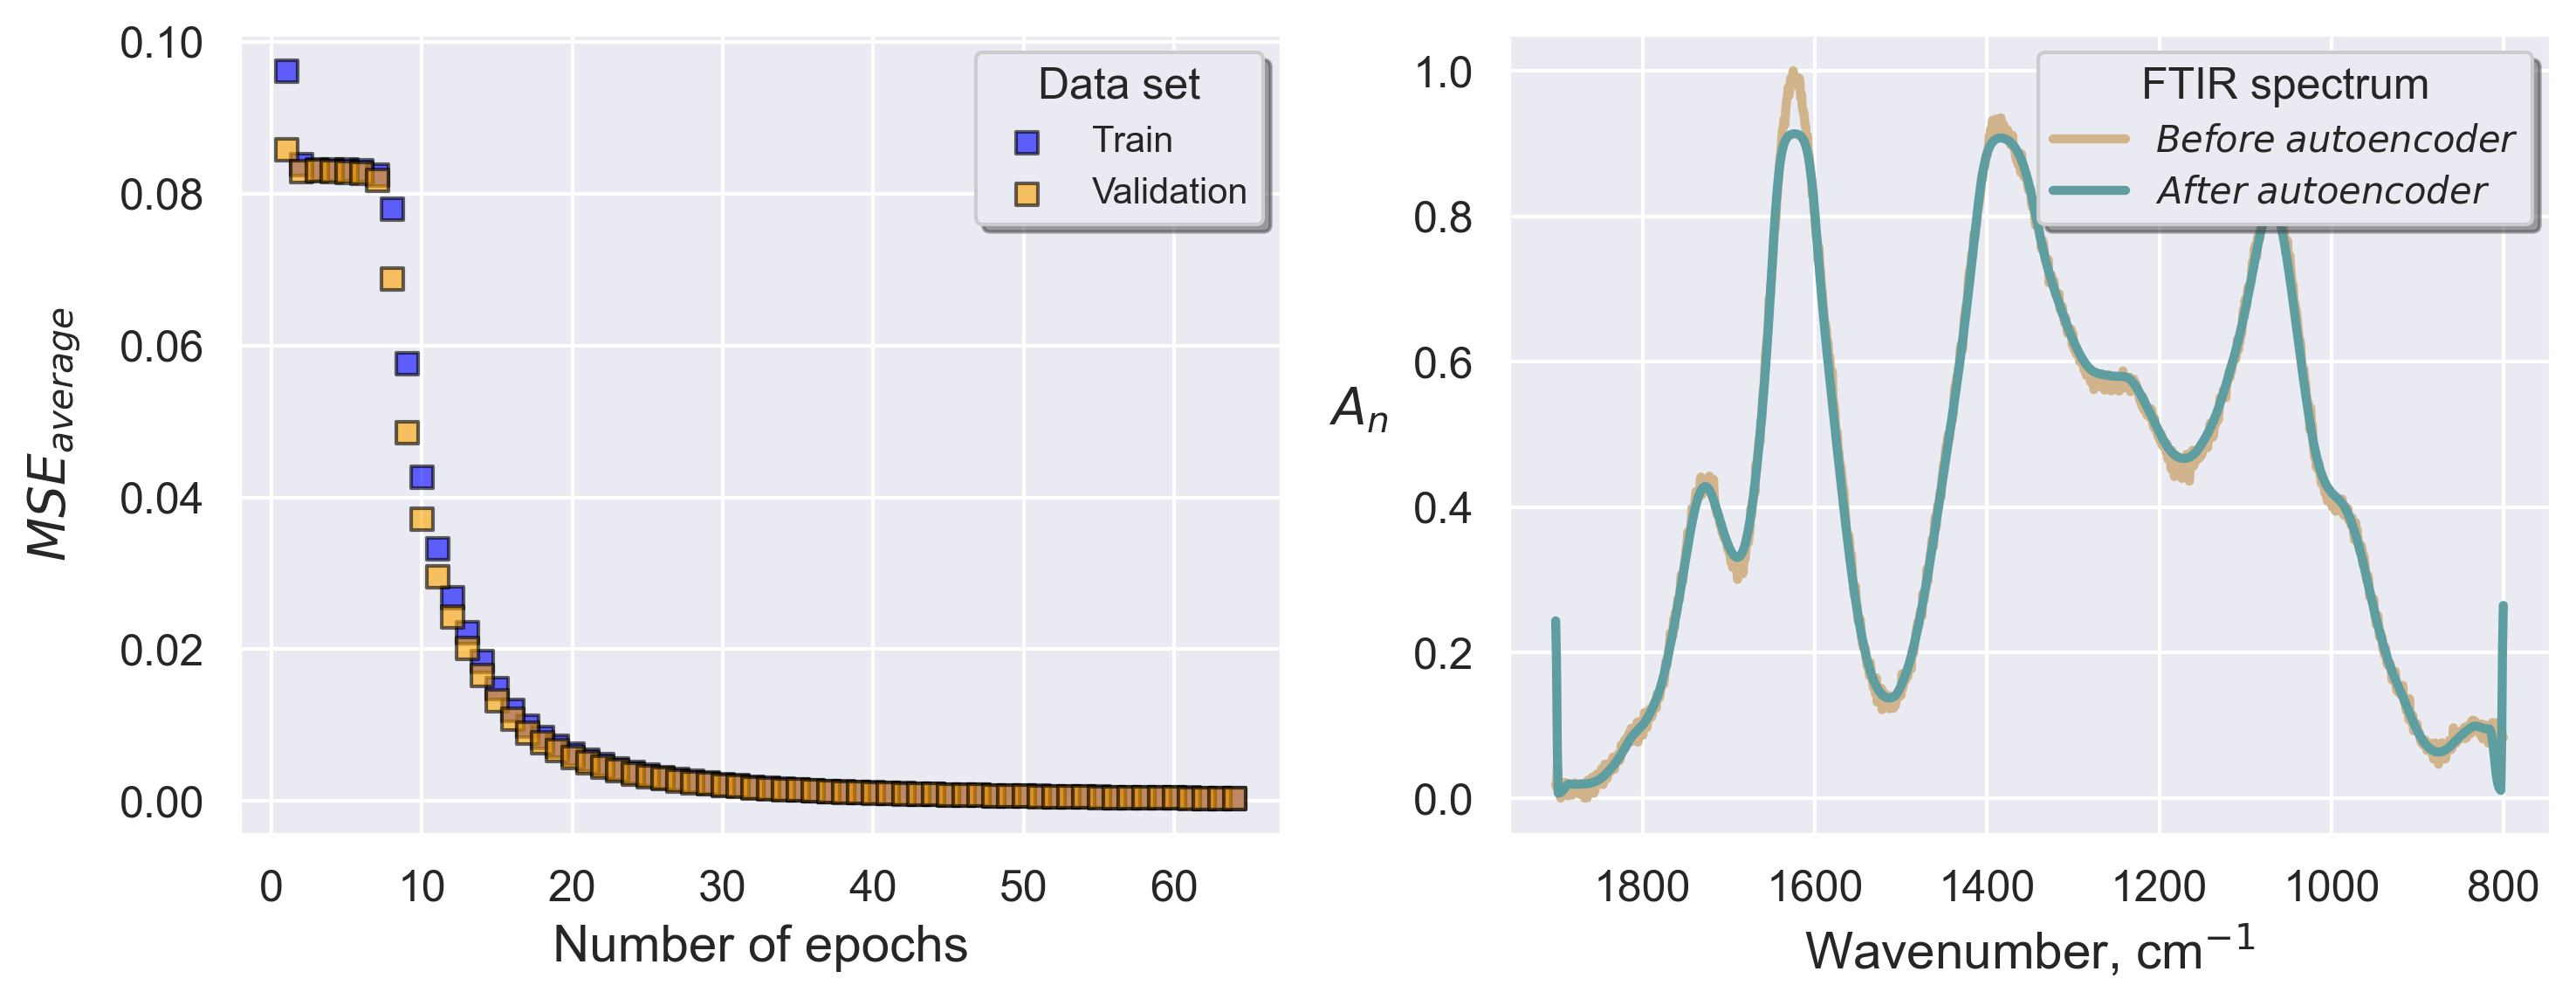

CPU times: user 5min 18s, sys: 2min 39s, total: 7min 57s
Wall time: 6min 4s


In [21]:
%%time

model = Autoencoder()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model=model,
      train_loader=train_dataloader,
      val_loader=val_dataloader,
      loss_function=loss_function,
      optimizer=optimizer,
      X=wavenumber,
      plot_every_n_epoch=4,
      n_epochs=64,
      stop_criteria=None,
      path_to_save=f'{path_to_save}/nn_training.png'
     )

# Clustering on embeddings

## Class for clustering on embeddings

In [36]:
class EmbeddingStructureAnalysis:
    def __init__(self, model):
        self.model = model

    def get_embedding(self, torch_data):
        _, embedding = self.model(torch_data)
        return pd.DataFrame(embedding.detach().numpy()[:, 0])

    def fit_transform_kmeans(self, train_data: pd.DataFrame, n_clusters: int, random_state: int = 42):
        estimator = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state)
        estimator.fit(train_data)

        self.n_clusters = n_clusters
        self.train_data = train_data
        self.estimator = estimator
        self.cluster_centers = estimator.cluster_centers_
        self.predictions = pd.DataFrame(estimator.predict(train_data), index=train_data.index, columns=['Prediction'])
        self.train_data_predictions = pd.concat([train_data, self.predictions], axis=1)

    def get_silhouette_score(self) -> float:
        return silhouette_score(self.train_data, self.estimator.labels_) if self.n_clusters >= 2 else None

    def get_inertia(self) -> float:
        return self.estimator.inertia_

    def get_metric_in_range(self, metric: str = 'silhouette', max_n_clusters: int = None) -> list:
        max_n_clusters = max_n_clusters or (self.train_data.shape[0] // 2)
        metric_values = []

        for n_clusters in tqdm(range(2, max_n_clusters + 1), desc=f'Computing {metric} values'):
            self.fit_transform_kmeans(train_data=self.train_data, n_clusters=n_clusters)
            metric_values.append(self.get_silhouette_score() if metric == 'silhouette' else self.get_inertia())

        return metric_values

    def get_metrics_visualization(self, metric: str = 'silhouette', max_n_clusters: int = None, figsize: tuple = (11, 7.5), path_to_save: str = None, dpi: int = 300):
        max_n_clusters = max_n_clusters or (self.train_data.shape[0] - 1)
        n_clusters = list(range(2, max_n_clusters + 1))
        metric_values = self.get_metric_in_range(metric, max_n_clusters)

        sns.set_theme()
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        sns.barplot(
            x=list(range(len(n_clusters))),
            y=metric_values, 
            palette='viridis', 
            ax=ax
        )

        ax.set_xlabel('Number of clusters', fontsize=16, labelpad=5)
        ax.set_ylabel('Silhouette score', fontsize=16, labelpad=5)
        ax.grid(True)

        ax.set_xticks(range(len(n_clusters)))
        ax.set_xticklabels(n_clusters, rotation=0, fontsize=12)

        plt.tight_layout()
        if path_to_save:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

    def get_spectra_clusters_visualization(self, data: pd.DataFrame, wavenumber: np.ndarray, n_clusters: int, nrows: int, ncols: int,
                                           figsize: tuple = (10, 6), color: str = 'dodgerblue', path_to_save: str = None, dpi: int = 300):
        if n_clusters > nrows * ncols:
            raise ValueError("Too many clusters for given subplot grid. Increase `nrows` or `ncols`.")

        self.fit_transform_kmeans(train_data=data, n_clusters=n_clusters)
        data_with_labels = self.train_data_predictions
        centroids = self.cluster_centers

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi)
        axes = axes.flatten()

        for i in range(nrows * ncols):
            if i >= n_clusters:
                axes[i].axis("off")
                continue

            temp_data = data_with_labels.loc[data_with_labels['Prediction'] == i].iloc[:, :-1].to_numpy()
            temp_centroid = centroids[i]

            for spectrum in temp_data:
                axes[i].plot(wavenumber, spectrum, linewidth=2.5, color=color)

            axes[i].plot(wavenumber, temp_centroid, linestyle='--', linewidth=2.5, color='black')

            axes[i].set_xlabel('Wavenumber, cm$^{-1}$', fontsize=12, labelpad=5)
            axes[i].set_ylabel('$A_{n}$', fontsize=12, labelpad=15, rotation=0)
            
            axes[i].invert_xaxis()

        plt.tight_layout()
        if path_to_save:
            plt.savefig(path_to_save, dpi=dpi)
        plt.show()

## Clustering

### *GO*

Computing silhouette values: 100%|████████████████| 6/6 [00:00<00:00, 80.19it/s]


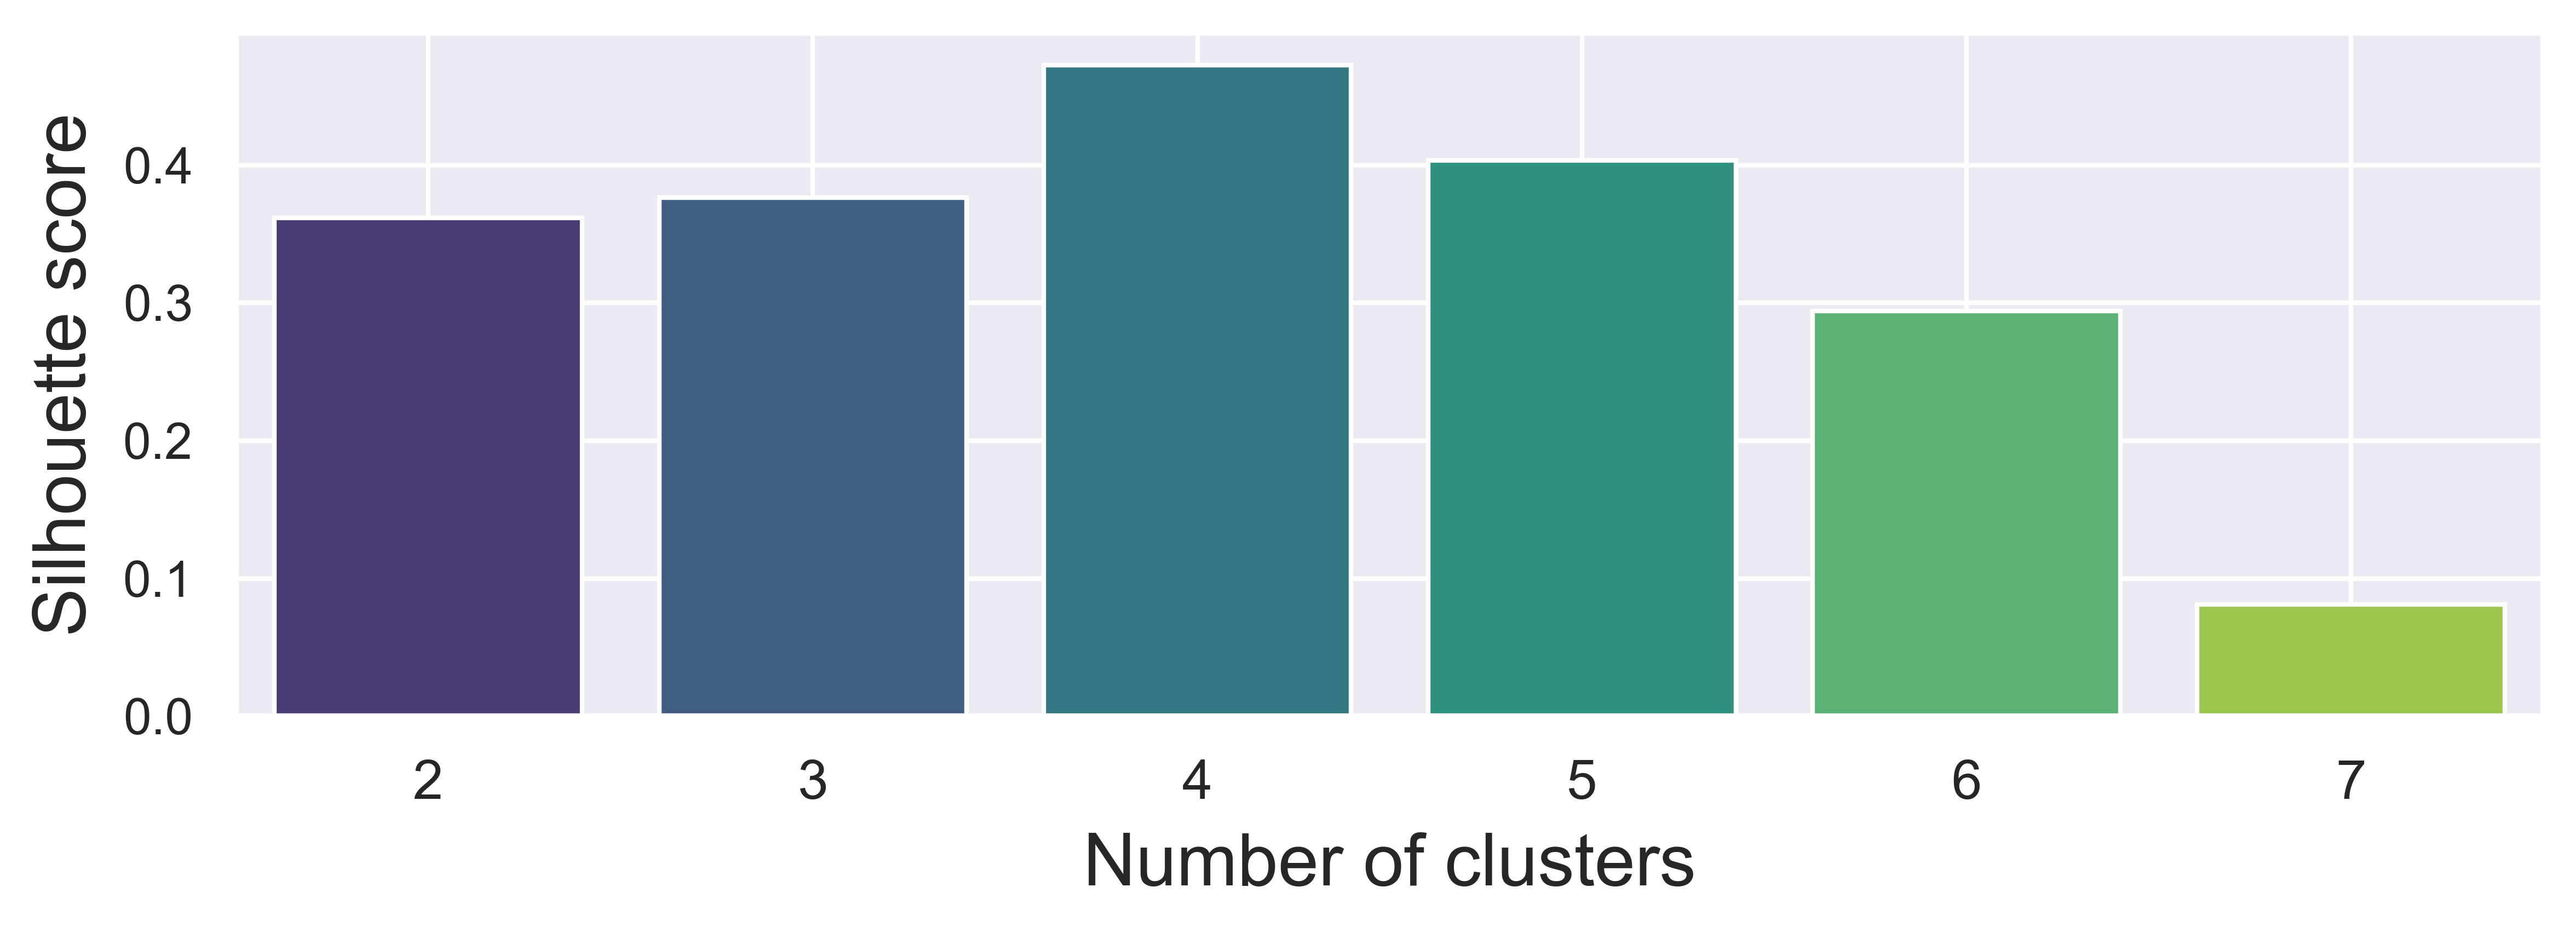

In [37]:
analyzer = EmbeddingStructureAnalysis(model=model)

emebedding = analyzer.get_embedding(go_data_torch)

analyzer.fit_transform_kmeans(train_data=emebedding, n_clusters=2)
analyzer.get_metrics_visualization(metric='silhouette', figsize=(8, 3), path_to_save=path_to_save + '/go_metrics.png', dpi=600)

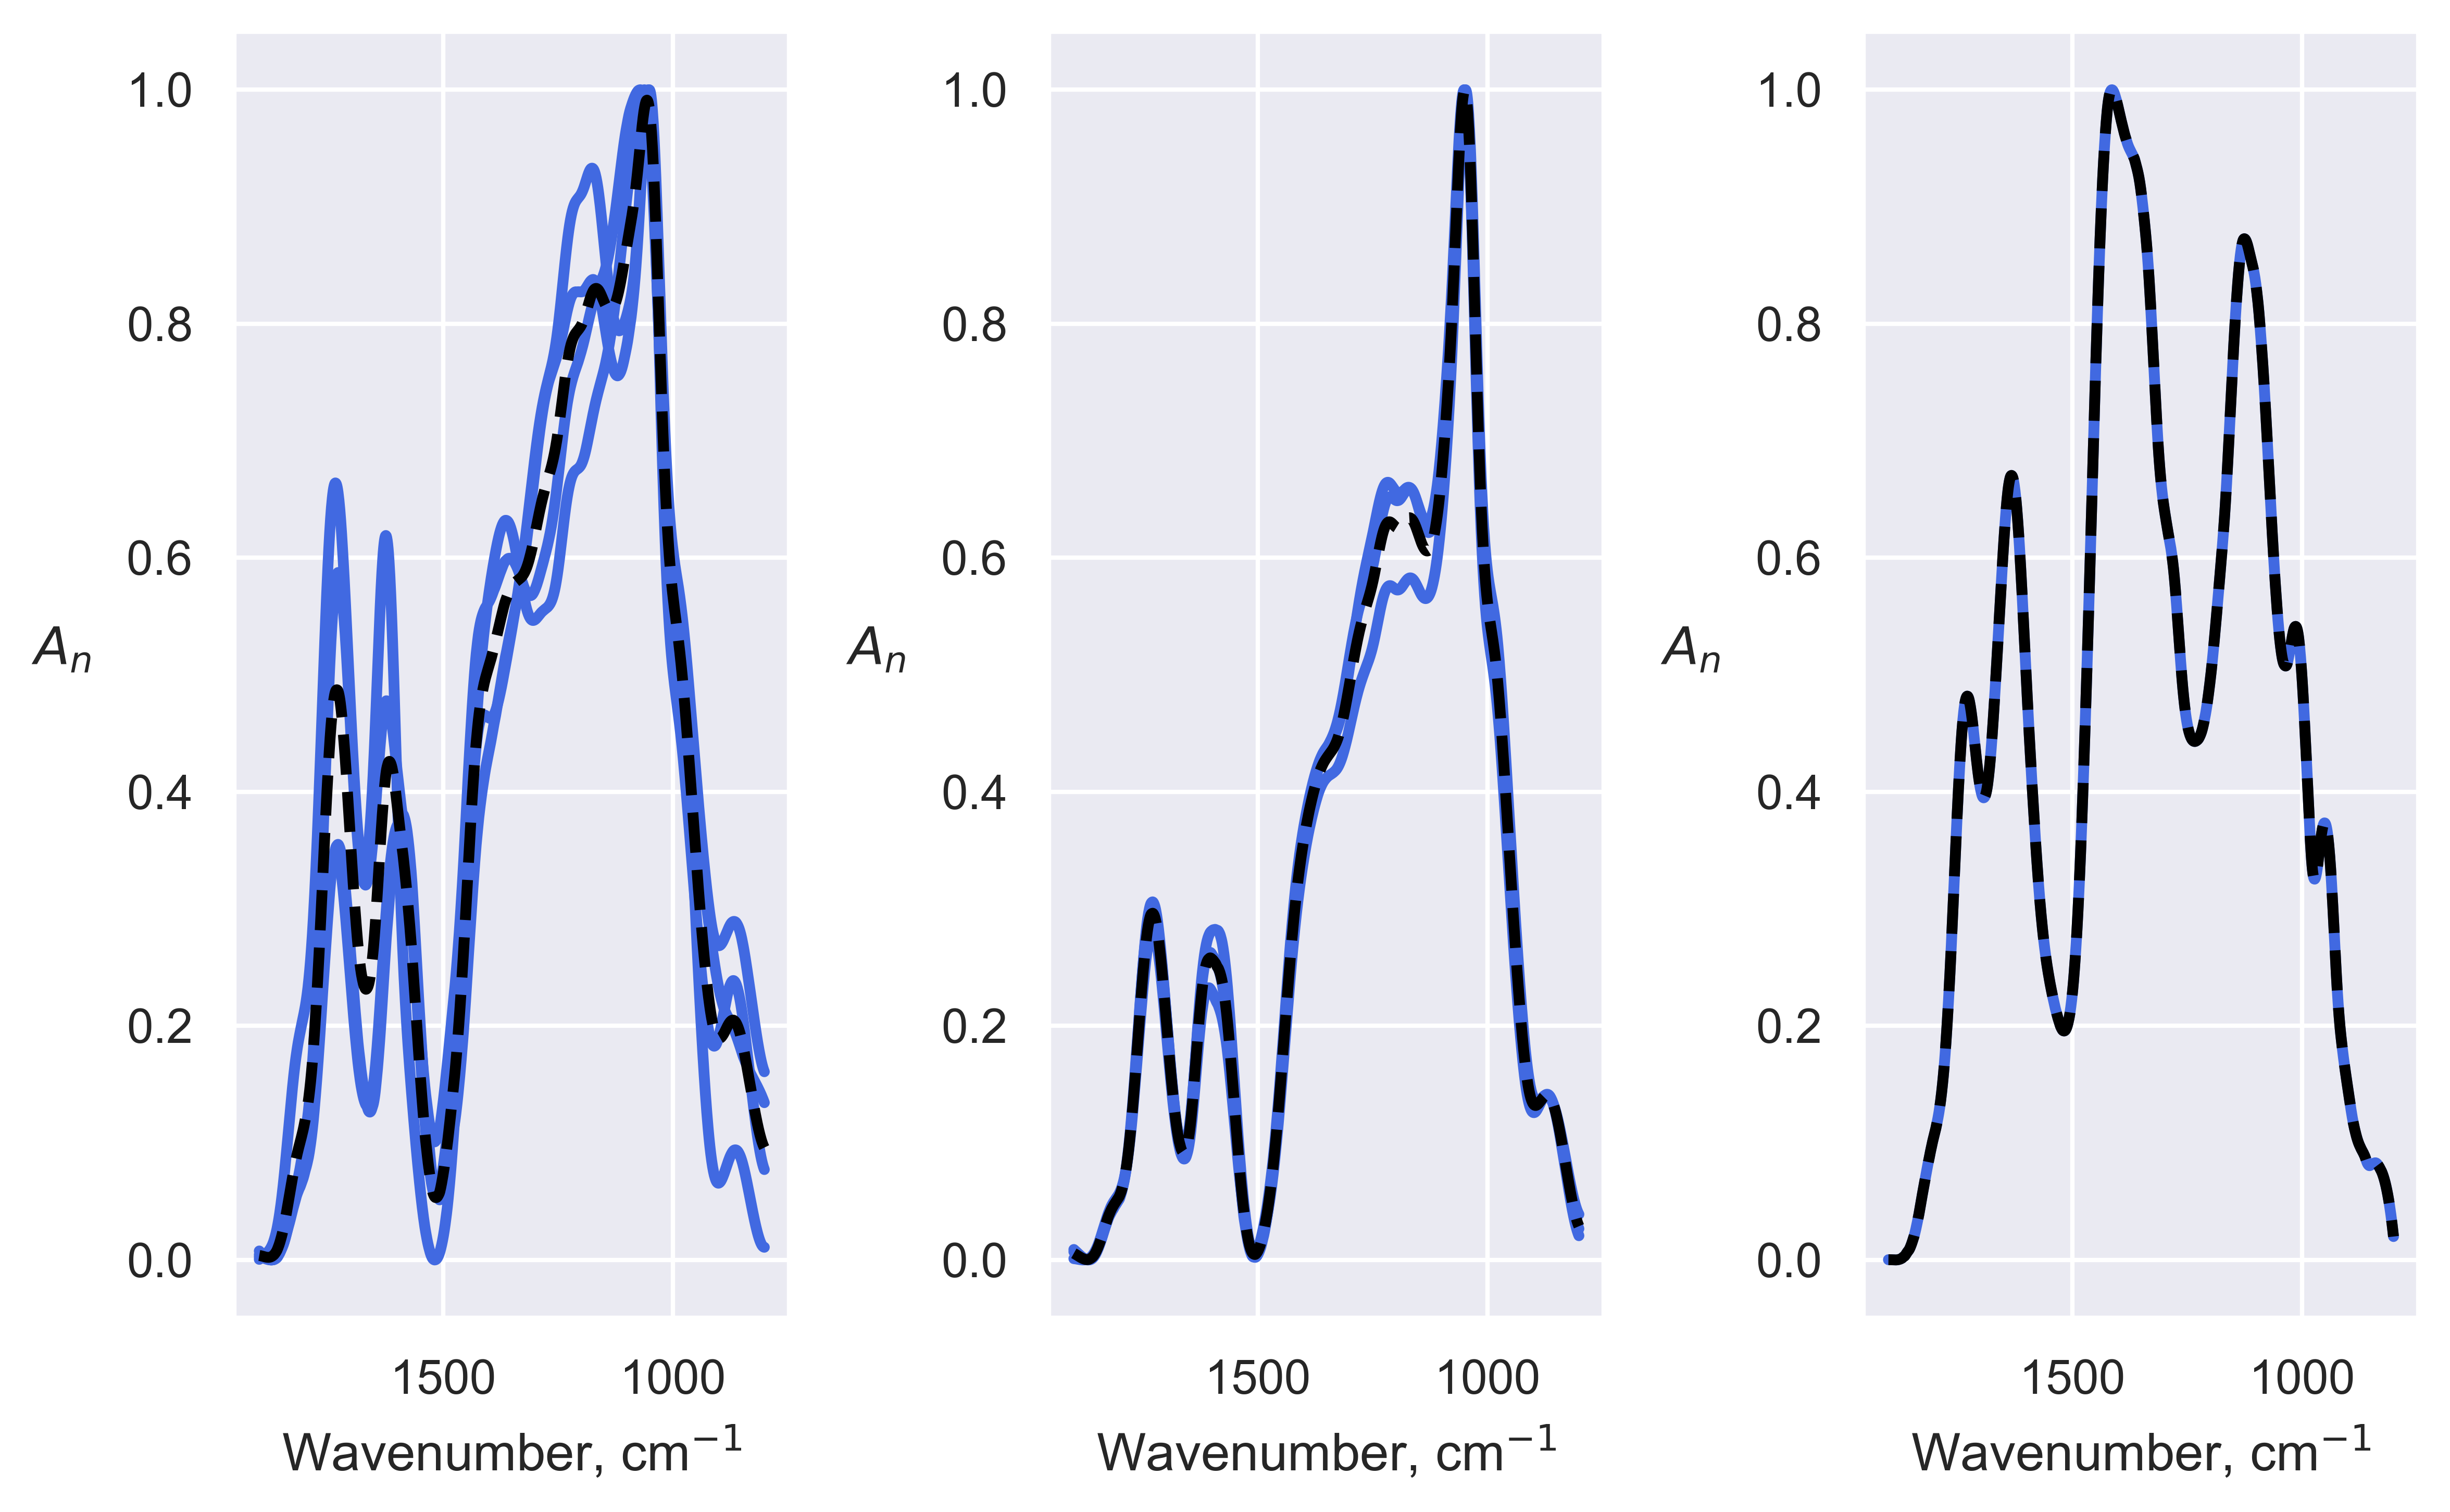

In [38]:
analyzer.get_spectra_clusters_visualization(data=go_data, wavenumber=wavenumber, n_clusters=3,
                                            ncols=3, nrows=1, figsize=(8, 5), color='RoyalBlue',
                                            path_to_save=path_to_save + '/go_clusters.png', dpi=600)

### *rGO*

Computing silhouette values: 100%|████████████████| 1/1 [00:00<00:00, 82.22it/s]


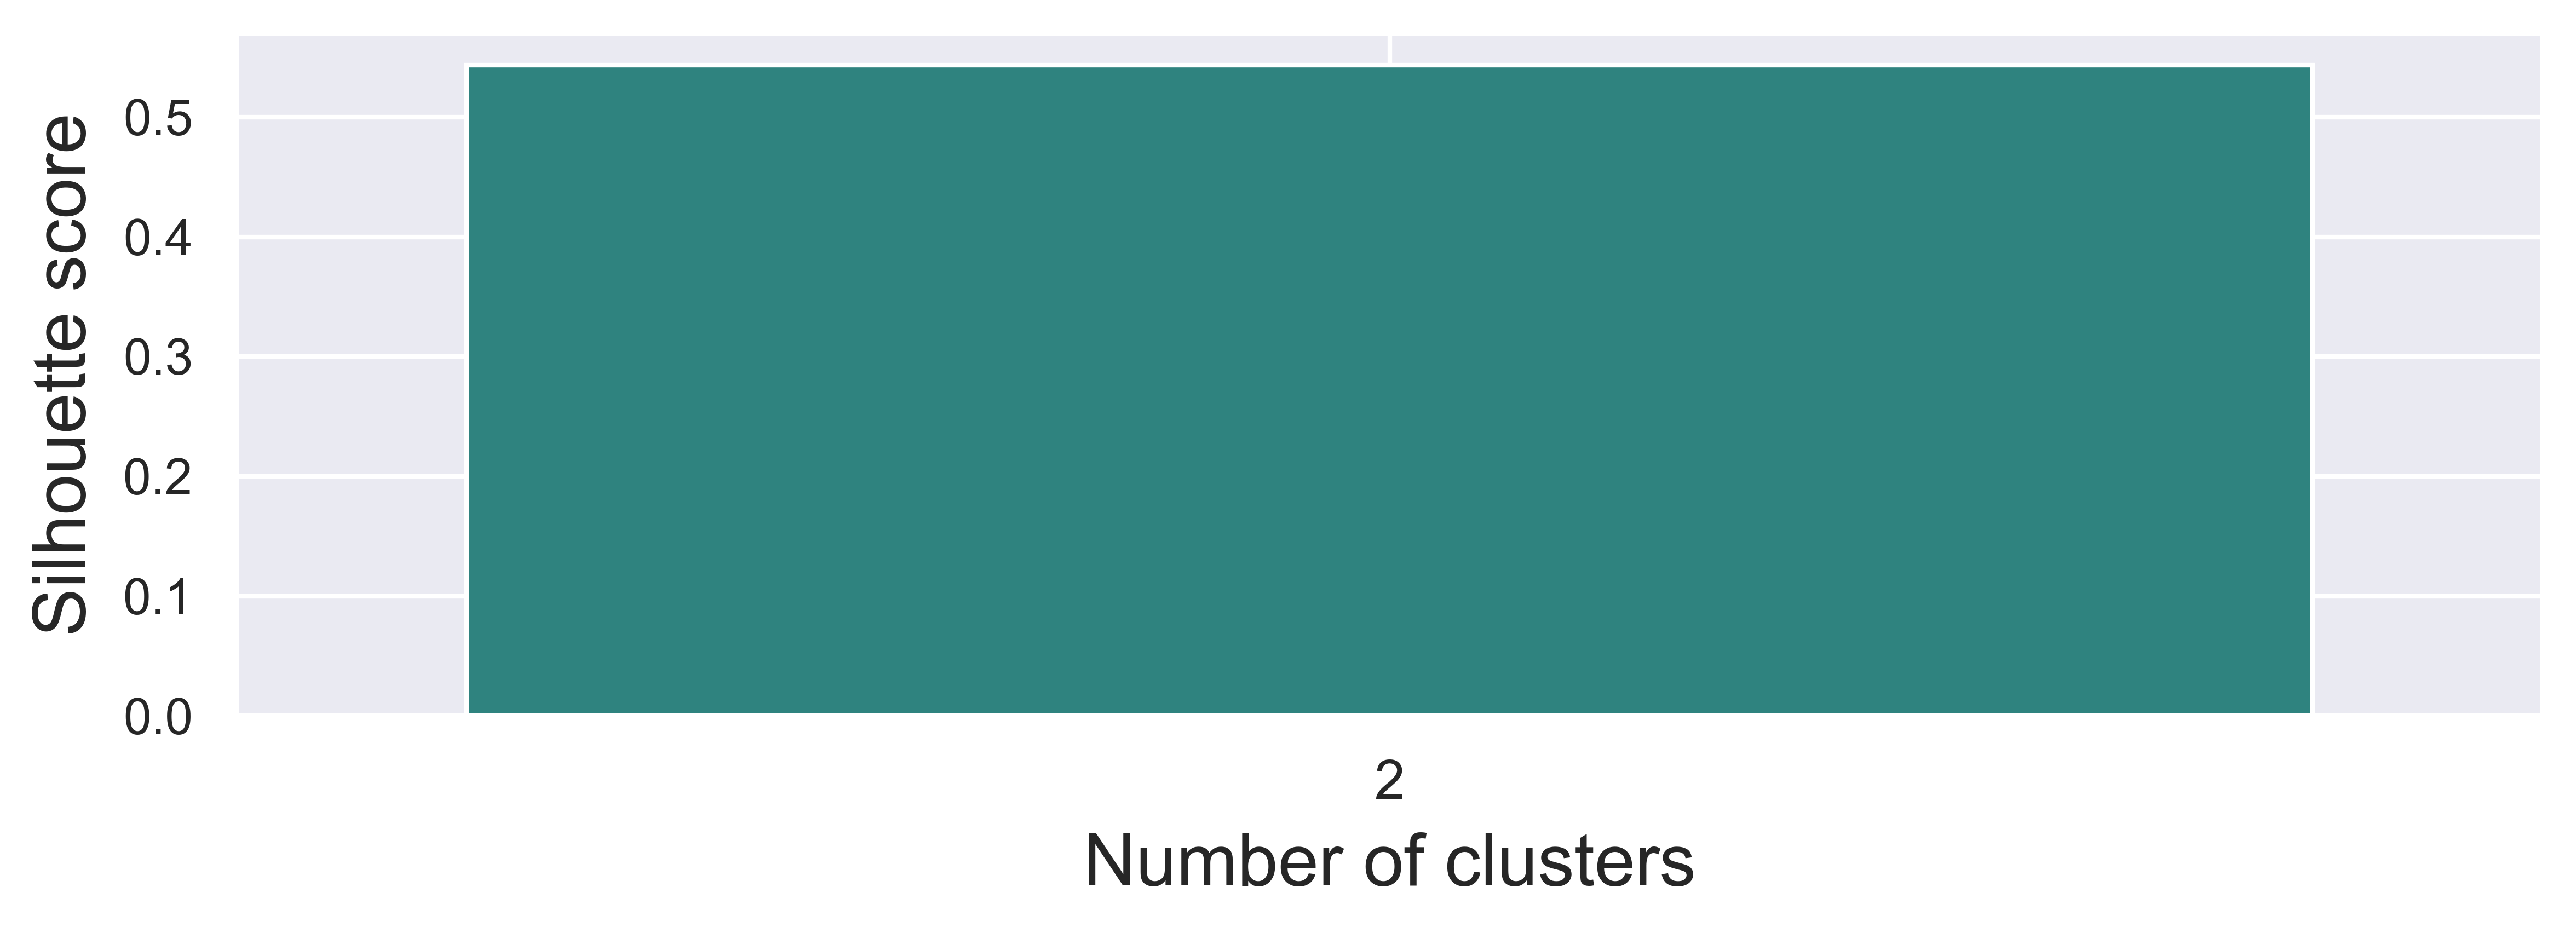

In [39]:
analyzer = EmbeddingStructureAnalysis(model=model)

emebedding = analyzer.get_embedding(rgo_data_torch)

analyzer.fit_transform_kmeans(train_data=emebedding, n_clusters=2)
analyzer.get_metrics_visualization(metric='silhouette', figsize=(8, 3), path_to_save=path_to_save + '/rgo_metrics.png', dpi=600)

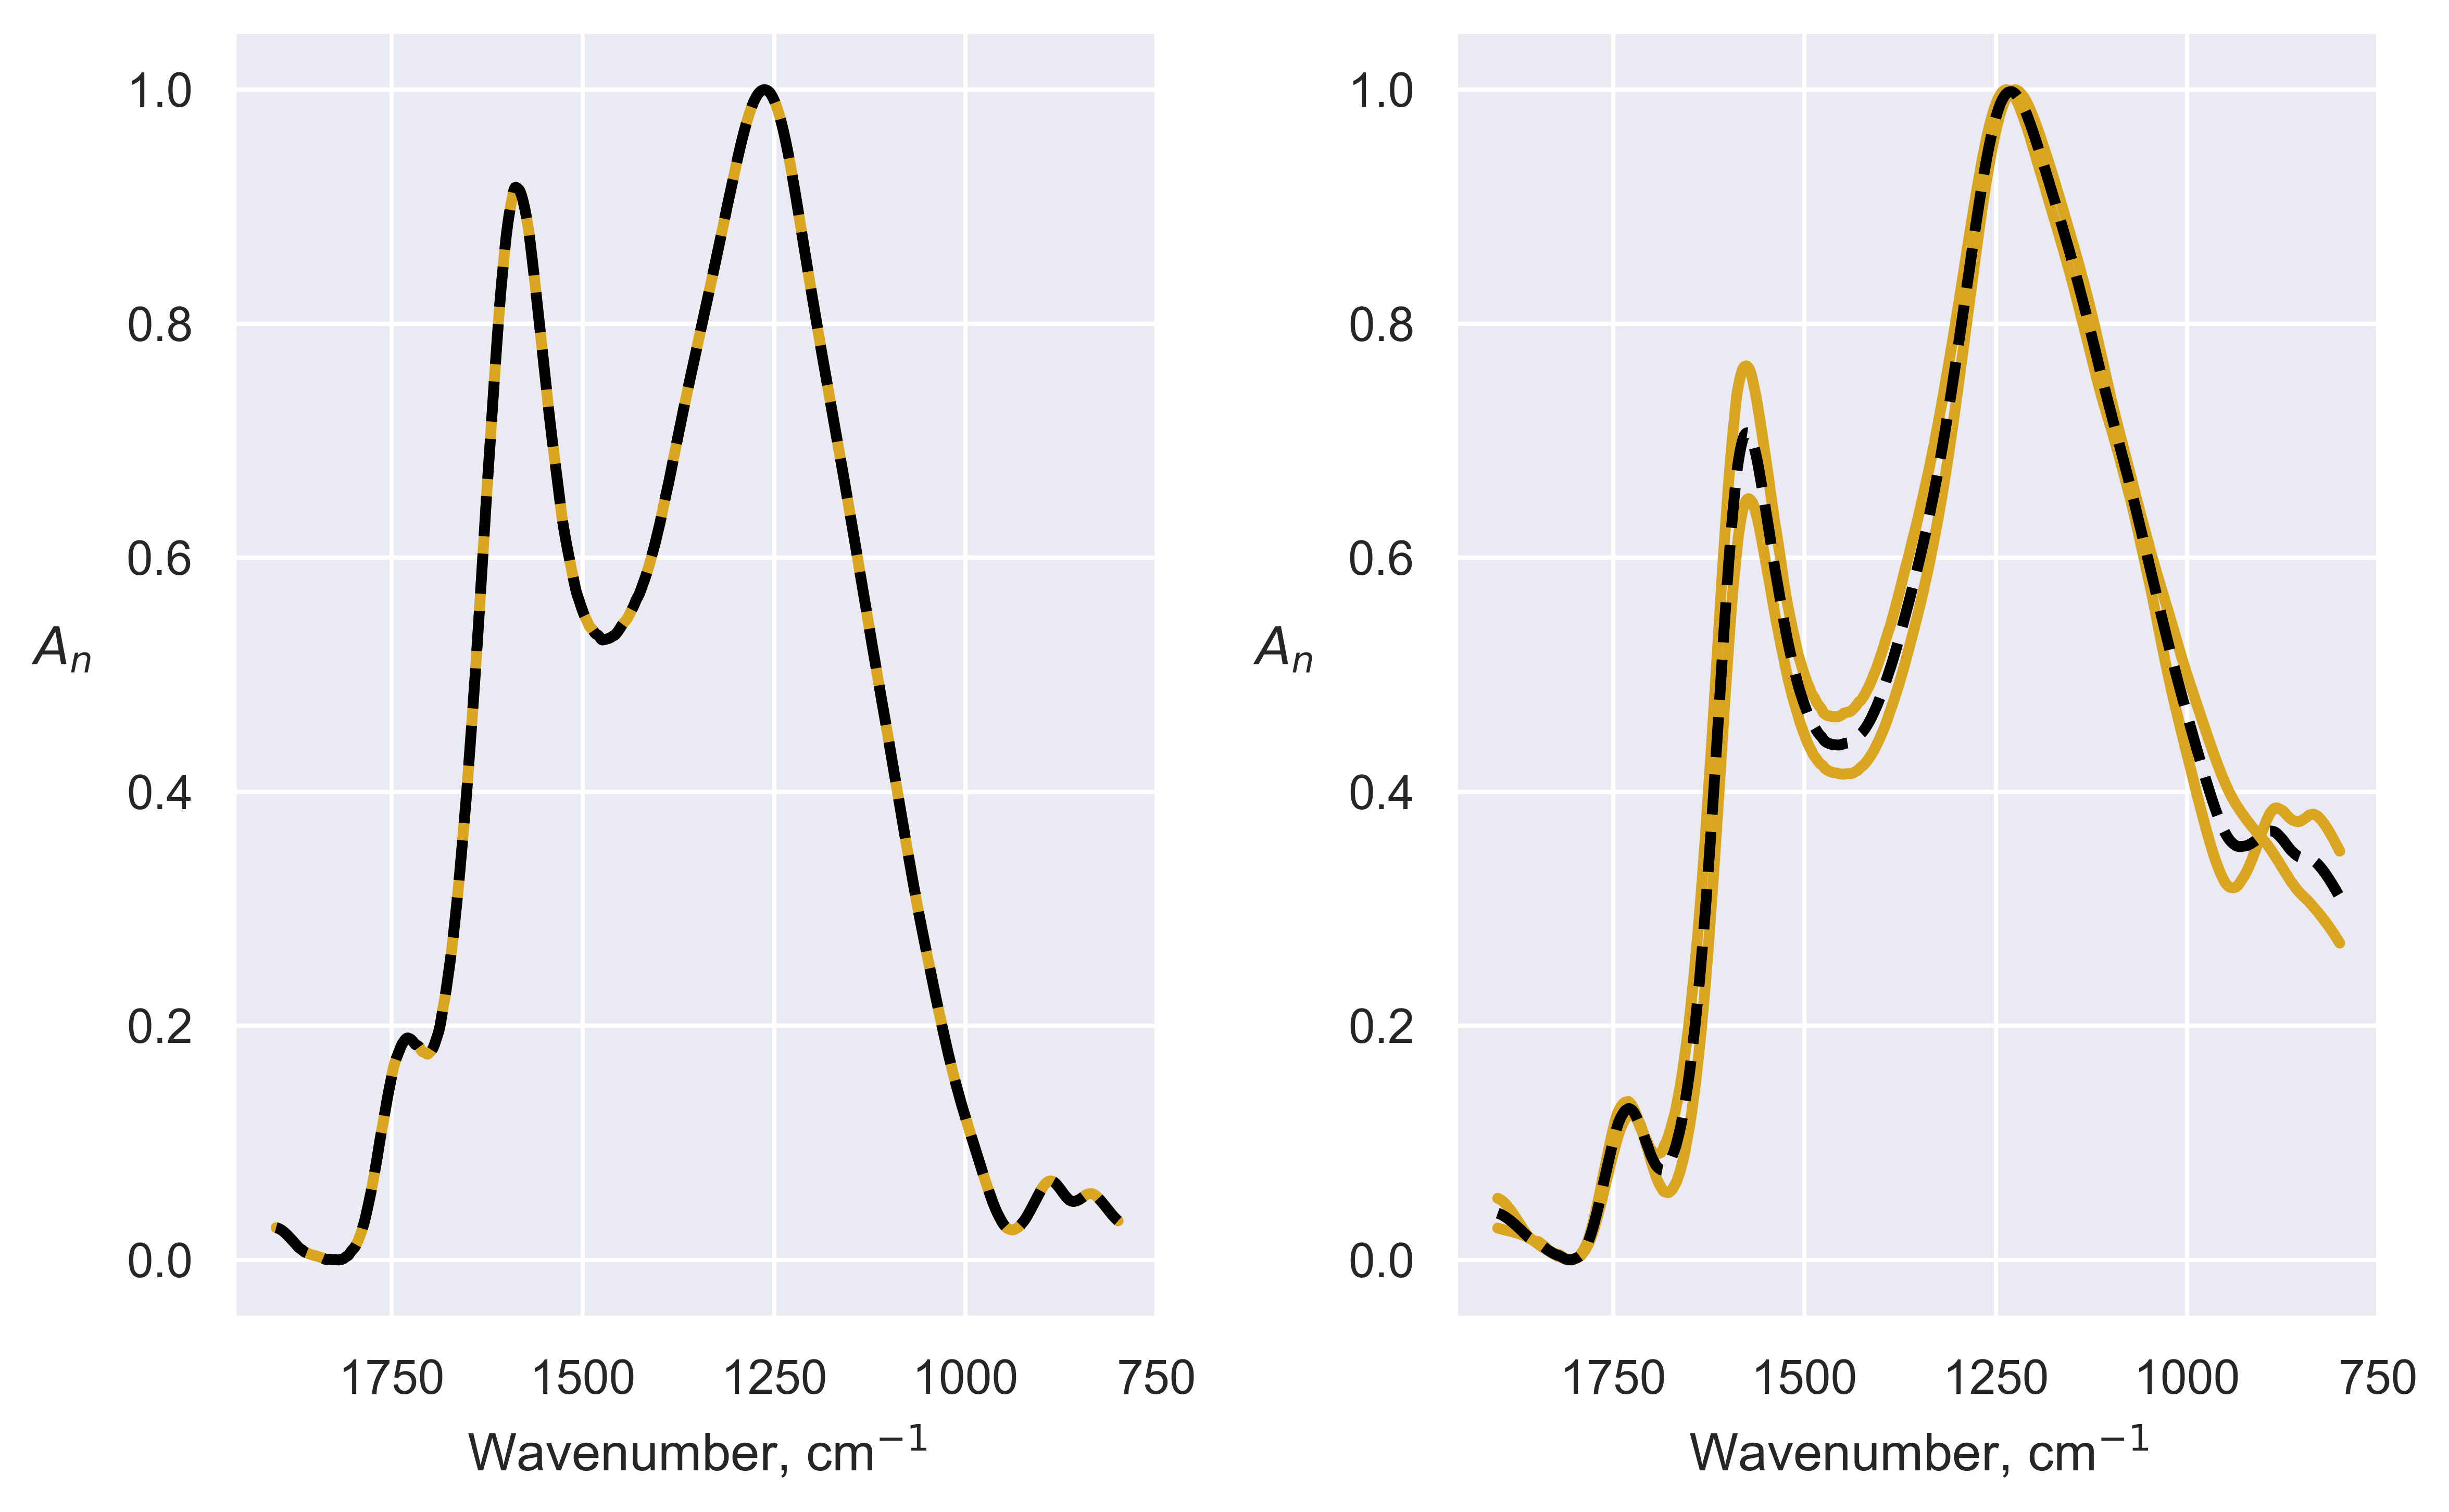

In [40]:
analyzer.get_spectra_clusters_visualization(data=rgo_data, wavenumber=wavenumber, n_clusters=2,
                                            ncols=2, nrows=1, figsize=(8, 5), color='Goldenrod',
                                            path_to_save=path_to_save + '/rgo_clusters.png', dpi=600)

### $GO_{d}$

Computing silhouette values: 100%|██████████████| 12/12 [00:00<00:00, 81.30it/s]


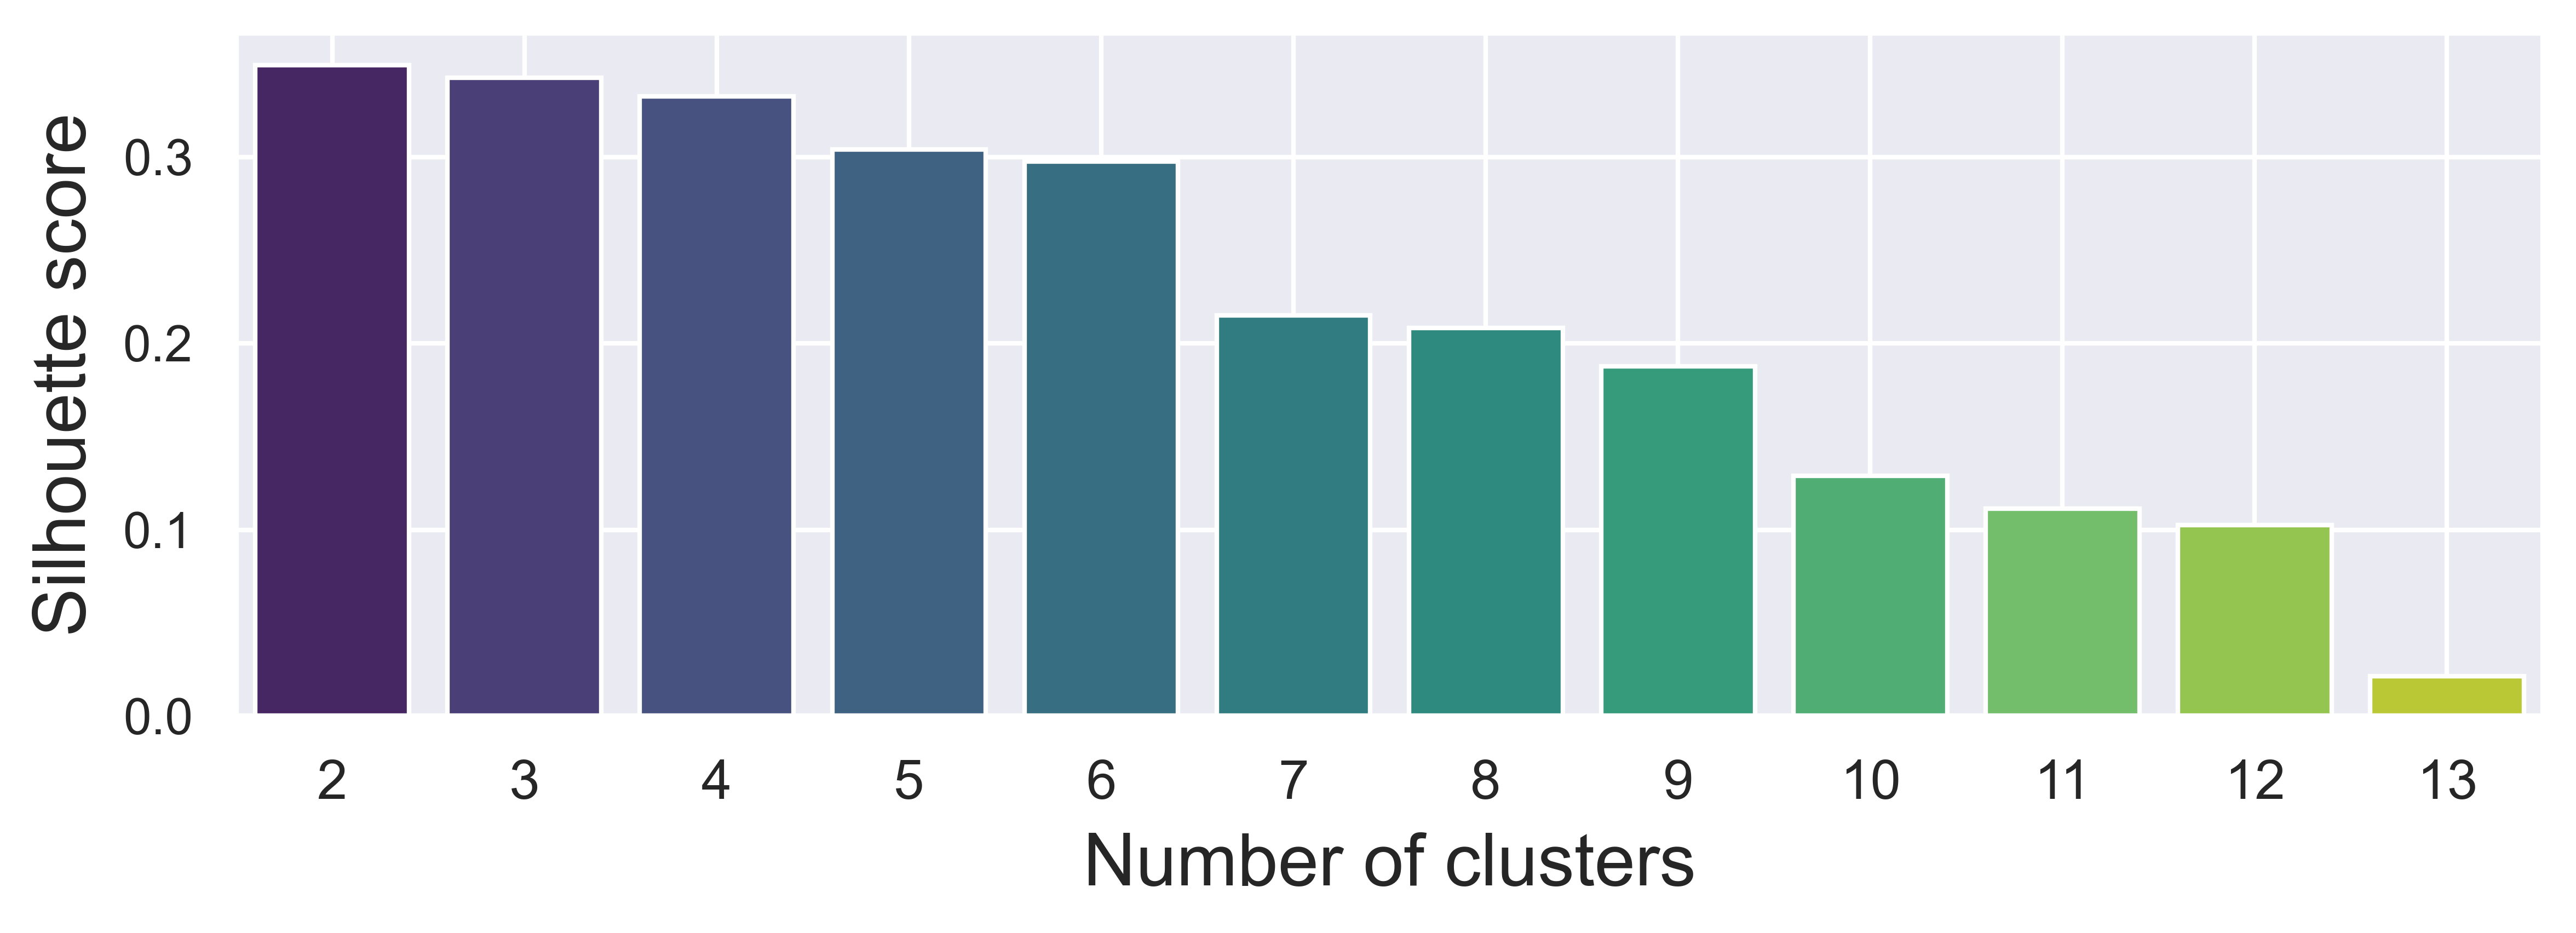

In [41]:
analyzer = EmbeddingStructureAnalysis(model=model)

emebedding = analyzer.get_embedding(god_data_torch)

analyzer.fit_transform_kmeans(train_data=emebedding, n_clusters=2)
analyzer.get_metrics_visualization(metric='silhouette', figsize=(8, 3), path_to_save=path_to_save + '/god_metrics.png', dpi=600)

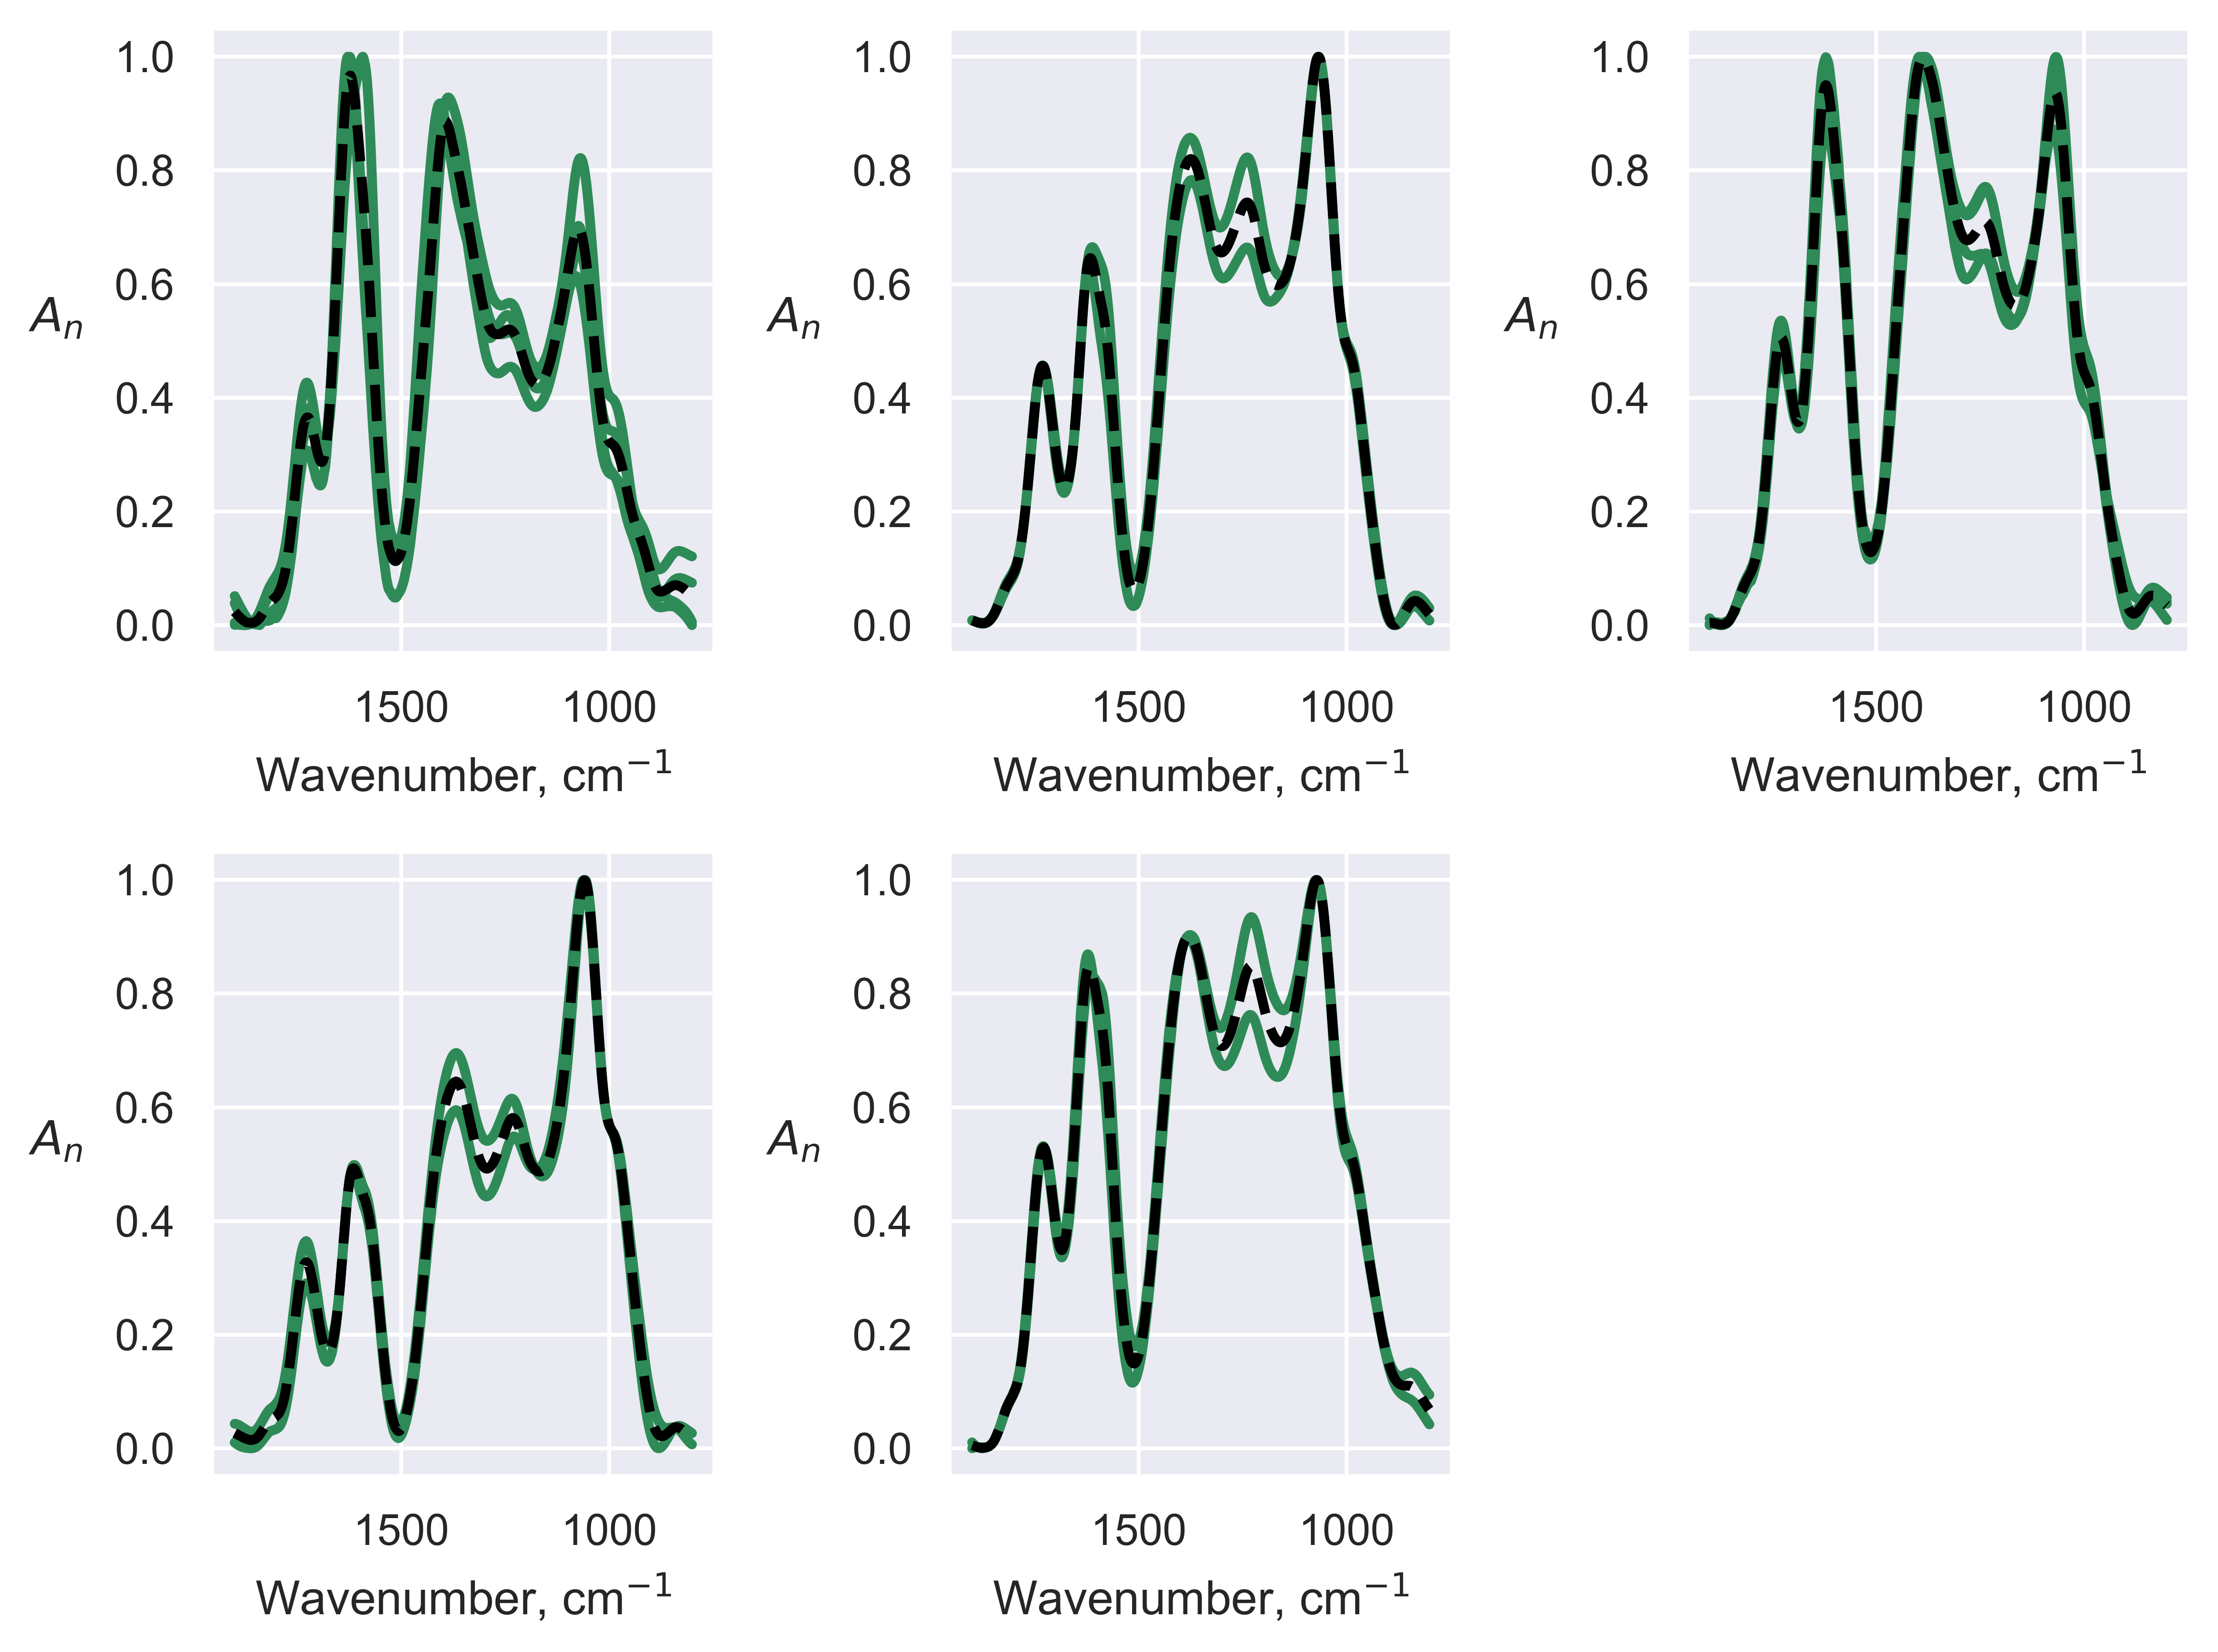

In [42]:
analyzer.get_spectra_clusters_visualization(data=god_data, wavenumber=wavenumber, n_clusters=5,
                                            ncols=3, nrows=2, figsize=(8, 6), color='SeaGreen',
                                            path_to_save=path_to_save + '/god_clusters.png', dpi=600)